In [1]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [ ]:
data_path = "liste_users.yaml"

with open(data_path, "r", encoding="utf-8") as f:
    users_list = yaml.load(f, Loader=yaml.FullLoader)

print("Nombre total d'utilisateurs :", len(users_list))

df = pd.DataFrame(users_list)
df.head()

Nombre total d'utilisateurs : 20000


,acquisition_channel,cancel_year_month,duration_month,fiber_or_adsl,has_retention,offer,recruit_year_month,sub_offer,total_bill
0,phone,2019-07,42,adsl,False,#11:Freebox Revolution with TV 3999eur,2016-01,11.4:Freebox Revolution with TV 3999eur,1810
1,online,2018-07,18,adsl,False,#11:Freebox Revolution with TV 3999eur,2017-01,11.4:Freebox Revolution with TV 3999eur,670
2,phone,2018-03,26,adsl,False,#11:Freebox Revolution with TV 3999eur,2016-01,11.4:Freebox Revolution with TV 3999eur,1030
3,phone,N/A,N/A,fiber,False,#11:Freebox Revolution with TV 3999eur,2017-01,11.4:Freebox Revolution with TV 3999eur,2470
4,phone,2019-02,37,adsl,False,#11:Freebox Revolution with TV 3999eur,2016-01,11.4:Freebox Revolution with TV 3999eur,2060


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   acquisition_channel  20000 non-null  object
 1   cancel_year_month    20000 non-null  object
 2   duration_month       20000 non-null  object
 3   fiber_or_adsl        20000 non-null  object
 4   has_retention        20000 non-null  bool  
 5   offer                20000 non-null  object
 6   recruit_year_month   20000 non-null  object
 7   sub_offer            20000 non-null  object
 8   total_bill           20000 non-null  int64 
dtypes: bool(1), int64(1), object(7)
memory usage: 1.2+ MB


In [4]:
df.replace("N/A", np.nan, inplace=True)


df["recruit_year_month"] = pd.to_datetime(
    df["recruit_year_month"],
    format="%Y-%m",
    errors="coerce"
)

df["cancel_year_month"] = pd.to_datetime(
    df["cancel_year_month"],
    format="%Y-%m",
    errors="coerce"
)


snapshot_date = pd.to_datetime("2022-01", format="%Y-%m")

C:\Users\setup game\AppData\Local\Temp\ipykernel_26544\1008438367.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("N/A", np.nan, inplace=True)


In [5]:
df.head(4)

,acquisition_channel,cancel_year_month,duration_month,fiber_or_adsl,has_retention,offer,recruit_year_month,sub_offer,total_bill
0,phone,2019-07-01,42.0,adsl,False,#11:Freebox Revolution with TV 3999eur,2016-01-01,11.4:Freebox Revolution with TV 3999eur,1810
1,online,2018-07-01,18.0,adsl,False,#11:Freebox Revolution with TV 3999eur,2017-01-01,11.4:Freebox Revolution with TV 3999eur,670
2,phone,2018-03-01,26.0,adsl,False,#11:Freebox Revolution with TV 3999eur,2016-01-01,11.4:Freebox Revolution with TV 3999eur,1030
3,phone,NaT,NaN,fiber,False,#11:Freebox Revolution with TV 3999eur,2017-01-01,11.4:Freebox Revolution with TV 3999eur,2470


In [6]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [7]:
total_na = df.isna().sum().sum()
print(f"Total valeurs manquantes : {total_na}")

# détail par colonne
print(df.isna().sum())


Total valeurs manquantes : 5596
acquisition_channel       0
cancel_year_month      2798
duration_month         2798
fiber_or_adsl             0
has_retention             0
offer                     0
recruit_year_month        0
sub_offer                 0
total_bill                0
dtype: int64


In [8]:
# la variable cible qui est churn : 1 si l'utilisateur a annulé son abonnement, 0 sinon
df["churn"] = np.where(df["cancel_year_month"].isna(), 0, 1)


active_mask = df["churn"] == 0
df.loc[active_mask, "tenure_months"] = (
    (snapshot_date.year - df.loc[active_mask, "recruit_year_month"].dt.year) * 12 +
    (snapshot_date.month - df.loc[active_mask, "recruit_year_month"].dt.month)
)


churned_mask = df["churn"] == 1
df["duration_month"] = pd.to_numeric(df["duration_month"], errors="coerce")
df.loc[churned_mask, "tenure_months"] = df.loc[churned_mask, "duration_month"].astype(float)


df["tenure_months"] = df["tenure_months"].astype(int)

df[["recruit_year_month", "cancel_year_month", "churn", "tenure_months"]].head()


,recruit_year_month,cancel_year_month,churn,tenure_months
0,2016-01-01,2019-07-01,1,42
1,2017-01-01,2018-07-01,1,18
2,2016-01-01,2018-03-01,1,26
3,2017-01-01,NaT,0,60
4,2016-01-01,2019-02-01,1,37


In [9]:
print("Churn rate global :", df['churn'].mean())
df['fiber_or_adsl'].value_counts()
df['has_retention'].value_counts()
df['offer'].value_counts()

Churn rate global : 0.7739355255716248


offer
#11:Freebox Revolution with TV 3999eur    8902
#8:Freebox Revolution 2999eur             3475
Name: count, dtype: int64

In [10]:
counts = df['churn'].value_counts().sort_index()
print(counts)
# Si tu veux un accès direct :
print("churn=0 :", counts.get(0, 0))
print("churn=1 :", counts.get(1, 0))

churn
0    2798
1    9579
Name: count, dtype: int64
churn=0 : 2798
churn=1 : 9579


Q1 :

In [11]:
cohort_counts = (
    df.groupby("recruit_year_month")
      .size()
      .reset_index(name="n_users")
      .sort_values("recruit_year_month")
)

cohort_counts

,recruit_year_month,n_users
0,2016-01-01,6879
1,2017-01-01,5498


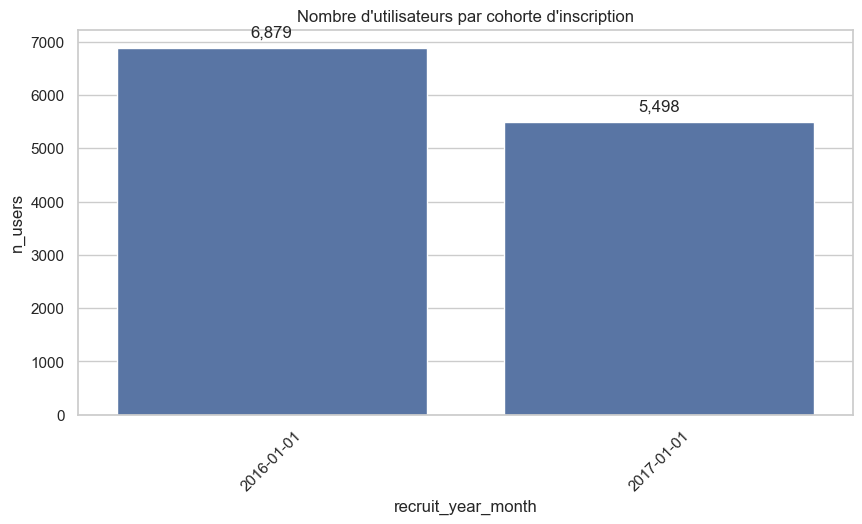

In [12]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=cohort_counts, x="recruit_year_month", y="n_users")


for i, row in cohort_counts.iterrows():
    ax.text(
        i,                              
        row["n_users"] + 200,           
        f"{row['n_users']:,}",          
        ha="center", fontsize=12
    )

plt.xticks(rotation=45)
plt.title("Nombre d'utilisateurs par cohorte d'inscription")
plt.ylabel("n_users")
plt.xlabel("recruit_year_month")
plt.show()


Q2 :

In [13]:
status = df["churn"].value_counts().rename(index={0: "Active", 1: "Churned"})
status

churn
Churned    9579
Active     2798
Name: count, dtype: int64

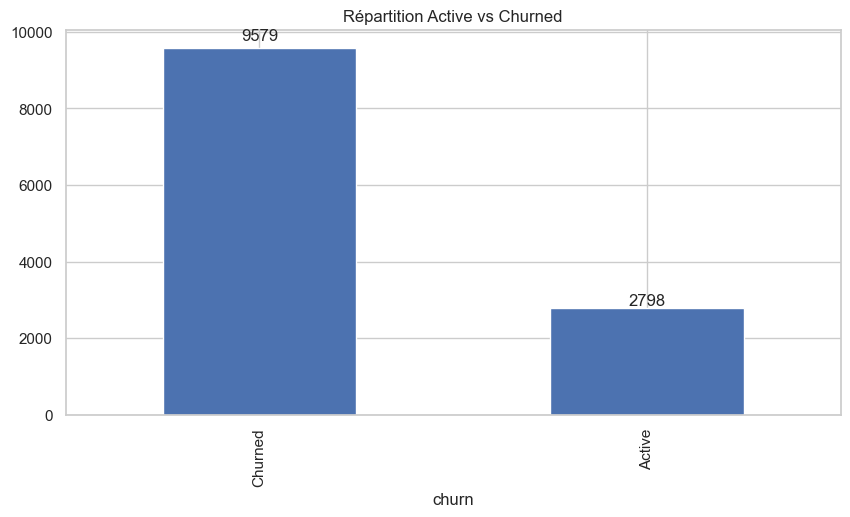

In [14]:
ax = status.plot(kind="bar", title="Répartition Active vs Churned")

# Ajouter les valeurs sur chaque barre
for i, value in enumerate(status):
    ax.text(
        i,                     # Position X
        value + (value * 0.02),# Position Y légèrement au-dessus
        f"{int(value)}",       # Texte affiché
        ha="center", fontsize=12
    )

plt.show()

In [15]:
churned = df[df["churn"] == 1]

churn_by_month = (
    churned.groupby("cancel_year_month")
           .size()
           .reset_index(name="n_churned")
           .sort_values("cancel_year_month")
)

churn_by_month

,cancel_year_month,n_churned
0,2016-01-01,17
1,2016-02-01,40
2,2016-03-01,54
3,2016-04-01,57
4,2016-05-01,70
...,...,...
68,2021-09-01,78
69,2021-10-01,61
70,2021-11-01,69
71,2021-12-01,73


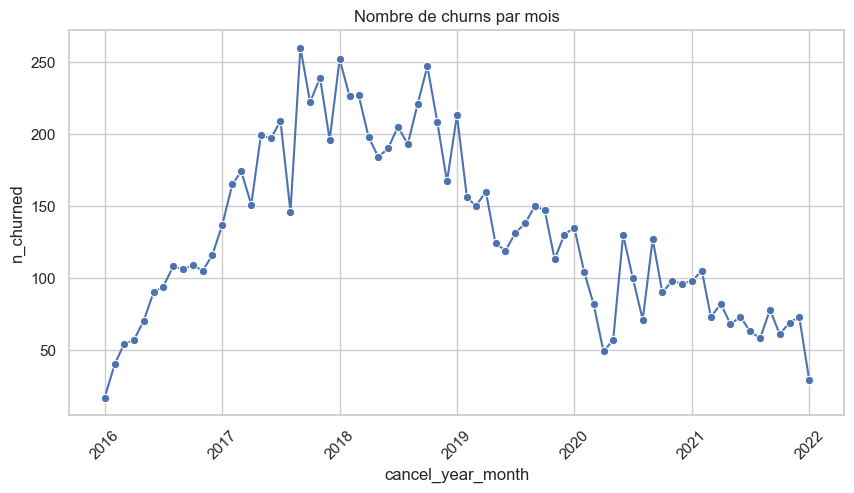

In [16]:
sns.lineplot(data=churn_by_month, x="cancel_year_month", y="n_churned", marker="o")
plt.xticks(rotation=45)
plt.title("Nombre de churns par mois")
plt.show()

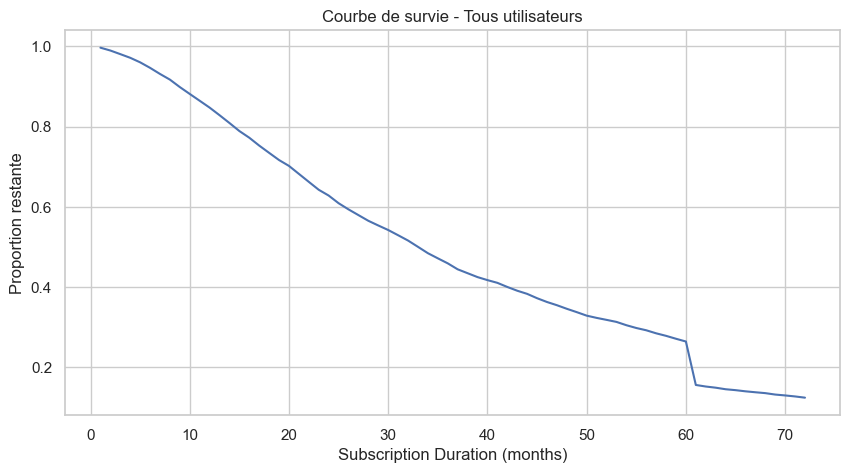

In [17]:
max_t = df["tenure_months"].max()
initial_users = len(df)

tenure_range = np.arange(1, max_t + 1)

remaining = [(df["tenure_months"] >= t).sum() for t in tenure_range]

survival_df = pd.DataFrame({
    "tenure_month": tenure_range,
    "share_remaining": np.array(remaining) / initial_users
})

sns.lineplot(data=survival_df, x="tenure_month", y="share_remaining")
plt.title("Courbe de survie - Tous utilisateurs")
plt.ylabel("Proportion restante")
plt.xlabel("Subscription Duration (months)")
plt.show()

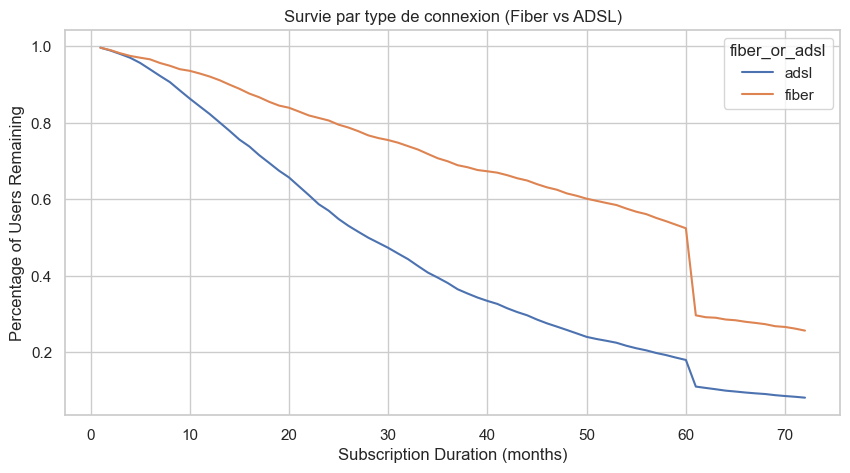

In [18]:
survival_group = []

for tech, df_group in df.groupby("fiber_or_adsl"):
    initial = len(df_group)
    for t in tenure_range:
        survival_group.append({
            "fiber_or_adsl": tech,
            "tenure_month": t,
            "share_remaining": (df_group["tenure_months"] >= t).sum() / initial
        })

survival_group_df = pd.DataFrame(survival_group)

sns.lineplot(
    data=survival_group_df,
    x="tenure_month",
    y="share_remaining",
    hue="fiber_or_adsl"
)
plt.title("Survie par type de connexion (Fiber vs ADSL)")
plt.ylabel("Percentage of Users Remaining")
plt.xlabel("Subscription Duration (months)")
plt.show()

Q3 :

In [19]:
churn_by_tenure = (
    df[df["churn"] == 1]
    .groupby("tenure_months")
    .size()
    .reindex(range(1, max_t + 1), fill_value=0)
)


remaining = len(df)
risk_set = []

for t in range(1, max_t + 1):
    risk_set.append(remaining)
    remaining -= churn_by_tenure.loc[t]


churn_rate = churn_by_tenure / risk_set

churn_rate_df = pd.DataFrame({
    "tenure_month": range(1, max_t + 1),
    "churn_rate": churn_rate.values
})

churn_rate_df.head()


,tenure_month,churn_rate
0,1,0.007110
1,2,0.009032
2,3,0.009279
3,4,0.011604
4,5,0.014256


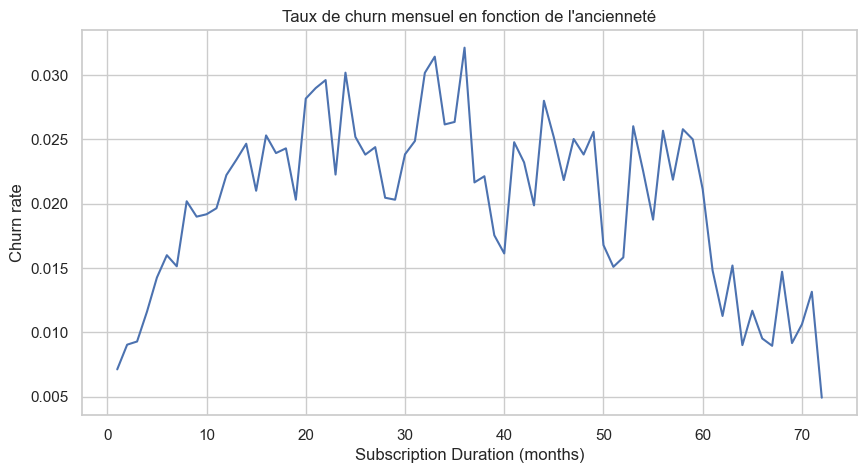

In [20]:
sns.lineplot(data=churn_rate_df, x="tenure_month", y="churn_rate")
plt.title("Taux de churn mensuel en fonction de l'ancienneté")
plt.ylabel("Churn rate")
plt.xlabel("Subscription Duration (months)")
plt.show()

# BILLS ANALYSIS
## Q1 :

In [21]:
df["total_bill"].describe()

count    12377.000000
mean      1652.839137
std       1296.750857
min          0.000000
25%        660.000000
50%       1420.000000
75%       2480.000000
max      43150.000000
Name: total_bill, dtype: float64

In [22]:
avg_bill_tech = df.groupby("fiber_or_adsl")["total_bill"].mean().reset_index()
avg_bill_tech

,fiber_or_adsl,total_bill
0,adsl,1463.013904
1,fiber,2239.184011


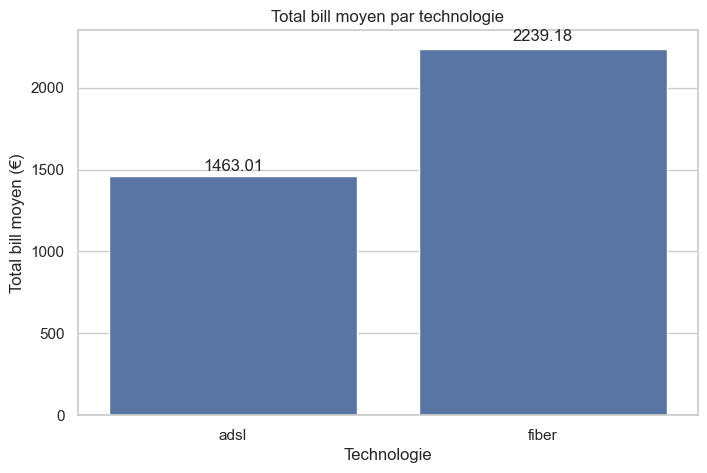

In [23]:
plt.figure(figsize=(8,5))
ax = sns.barplot(data=avg_bill_tech, x="fiber_or_adsl", y="total_bill")

# Ajouter les valeurs exactes sur chaque barre
for i, row in avg_bill_tech.iterrows():
    ax.text(
        i,                                   # Position X
        row["total_bill"] + (row["total_bill"] * 0.02),  # Position Y juste au-dessus
        f"{row['total_bill']:.2f}",          # Valeur formatée (2 décimales)
        ha="center", fontsize=12
    )

plt.title("Total bill moyen par technologie")
plt.ylabel("Total bill moyen (€)")
plt.xlabel("Technologie")
plt.show()

In [24]:
avg_bill_ret = df.groupby("has_retention")["total_bill"].mean().reset_index()
avg_bill_ret

,has_retention,total_bill
0,False,1617.622971
1,True,2518.181818


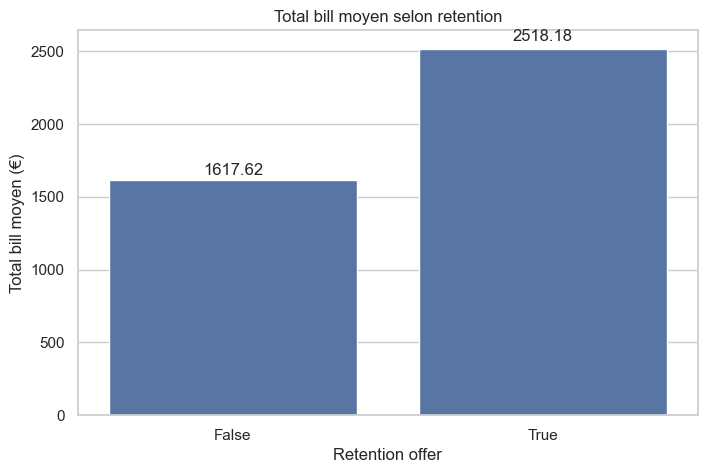

In [25]:
plt.figure(figsize=(8,5))
ax = sns.barplot(data=avg_bill_ret, x="has_retention", y="total_bill")

# Ajouter les valeurs exactes sur chaque barre
for i, row in avg_bill_ret.iterrows():
    ax.text(
        i,                                   # Position X
        row["total_bill"] + (row["total_bill"] * 0.02),  # Position Y légèrement au-dessus
        f"{row['total_bill']:.2f}",          # Affichage avec 2 décimales
        ha="center", fontsize=12
    )

plt.title("Total bill moyen selon retention")
plt.ylabel("Total bill moyen (€)")
plt.xlabel("Retention offer")
plt.show()

Q2 :

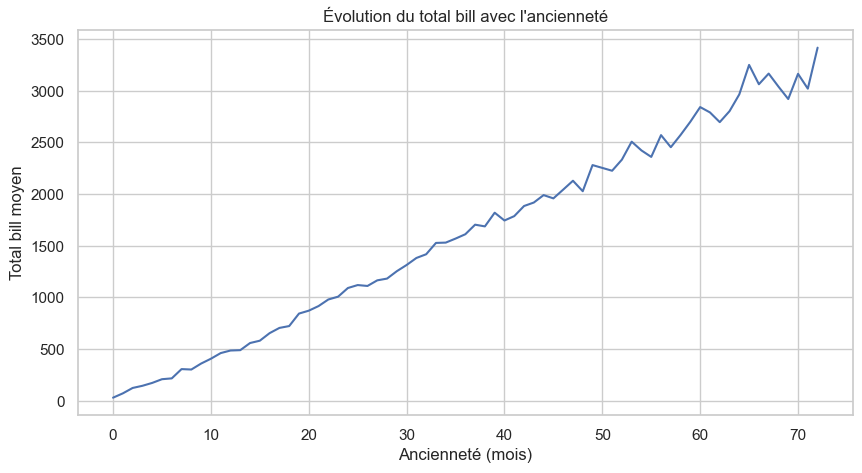

In [26]:
bill_by_tenure = (
    df.groupby("tenure_months")["total_bill"]
      .mean()
      .reset_index()
      .sort_values("tenure_months")
)

sns.lineplot(data=bill_by_tenure, x="tenure_months", y="total_bill")
plt.title("Évolution du total bill avec l'ancienneté")
plt.xlabel("Ancienneté (mois)")
plt.ylabel("Total bill moyen")
plt.show()

# Complementary Analysis
## Churn Prediction

### Feature engineering

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [28]:
required_cols = [
    "churn",
    "tenure_months",
    "total_bill",
    "fiber_or_adsl",
    "has_retention",
    "offer",
    "sub_offer",
    "acquisition_channel",
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in df: {missing}")

df["churn"] = df["churn"].astype(int)

# STRATIFIED SPLIT

In [29]:
features = [
    "tenure_months",
    "total_bill",
    "fiber_or_adsl",
    "has_retention",
    "offer",
    "sub_offer",
    "acquisition_channel",
]

X = df[features]
y = df["churn"]

In [30]:
cat_cols = [
    "fiber_or_adsl",
    "has_retention",
    "offer",
    "sub_offer",
    "acquisition_channel",
]

num_cols = [
    "tenure_months",
    "total_bill",
]

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

In [33]:
base_models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    ),
}

In [34]:
base_results = {}
base_pipelines = {}

print("\n===== BASE MODELS =====")

for name, model in base_models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    
    auc = roc_auc_score(y_test, y_proba)
    base_results[name] = auc
    base_pipelines[name] = pipe
    
    print(f"\n>>> {name}")
    print("ROC-AUC:", round(auc, 4))
    print(classification_report(y_test, y_pred, digits=3))



===== BASE MODELS =====

>>> Logistic Regression
ROC-AUC: 0.9815
              precision    recall  f1-score   support

           0      0.800     0.999     0.888       700
           1      1.000     0.927     0.962      2395

    accuracy                          0.943      3095
   macro avg      0.900     0.963     0.925      3095
weighted avg      0.954     0.943     0.945      3095


>>> Random Forest
ROC-AUC: 0.9977
              precision    recall  f1-score   support

           0      0.972     0.999     0.985       700
           1      1.000     0.992     0.996      2395

    accuracy                          0.993      3095
   macro avg      0.986     0.995     0.990      3095
weighted avg      0.993     0.993     0.993      3095


>>> Gradient Boosting
ROC-AUC: 0.9982
              precision    recall  f1-score   support

           0      0.972     1.000     0.986       700
           1      1.000     0.992     0.996      2395

    accuracy                          0.99

In [36]:
best_base_model_name = max(base_results, key=base_results.get)
best_base_model = base_pipelines[best_base_model_name]

print("\nBest baseline model:", best_base_model_name)
print("ROC-AUC:", round(base_results[best_base_model_name], 4))



Best baseline model: Gradient Boosting
ROC-AUC: 0.9982


GRID SEARCH

In [37]:
param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [10, 14, 18],
    "model__min_samples_split": [2, 5, 10],
}


In [38]:
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        class_weight="balanced",
        random_state=42
    ))
])


In [39]:
grid = GridSearchCV(
    pipe_rf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['fiber_or_adsl',
                                                                          'has_retention',
                                                                          'offer',
                                                                          'sub_offer',
                                                                          'acquisition_channel']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['tenure_months',
                                                                          'total_bill'])])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 14, 18],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [200, 400, 600]},
             scoring='roc_auc')

In [40]:
best_churn_model = grid.best_estimator_

print("\n===== BEST RANDOM FOREST (GRID SEARCH) =====")
print("Best params:", grid.best_params_)


===== BEST RANDOM FOREST (GRID SEARCH) =====
Best params: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 200}


In [41]:
y_proba_final = best_churn_model.predict_proba(X_test)[:, 1]
y_pred_final = best_churn_model.predict(X_test)

print("\n===== FINAL MODEL PERFORMANCE =====")
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_final), 4))
print(classification_report(y_test, y_pred_final, digits=3))


===== FINAL MODEL PERFORMANCE =====
ROC-AUC: 0.9983
              precision    recall  f1-score   support

           0      0.952     1.000     0.976       700
           1      1.000     0.985     0.993      2395

    accuracy                          0.989      3095
   macro avg      0.976     0.993     0.984      3095
weighted avg      0.989     0.989     0.989      3095



In [42]:
# Ajouter p_churn TO DATASET
df["p_churn"] = best_churn_model.predict_proba(X)[:, 1]

import os
os.makedirs("outputs", exist_ok=True)

df.to_csv("outputs/fake_users_with_p_churn.csv", index=False)


ADVANCED RETENTION ANALYSIS

    has_retention  churn_rate      n  churn_rate_pct
0  Sans rétention    0.794501  11893       79.450097
1  Avec rétention    0.268595    484       26.859504


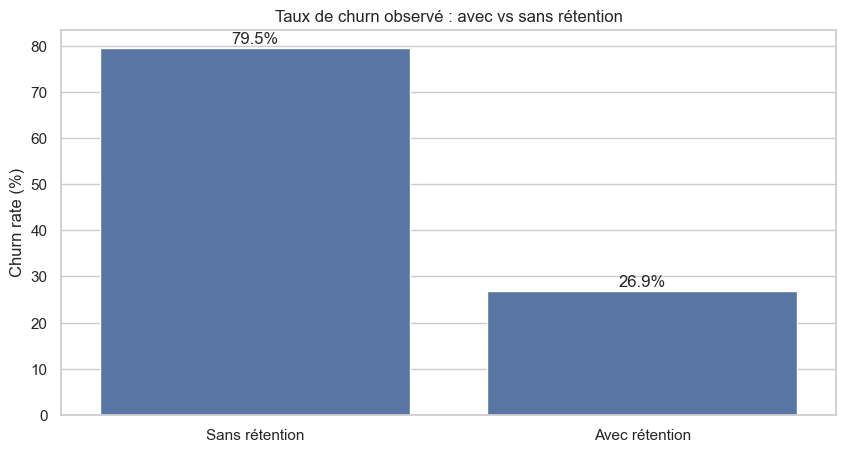

                Actifs (churn=0)  Churnés (churn=1)
has_retention                                      
Sans rétention         20.549903          79.450097
Avec rétention         73.140496          26.859504


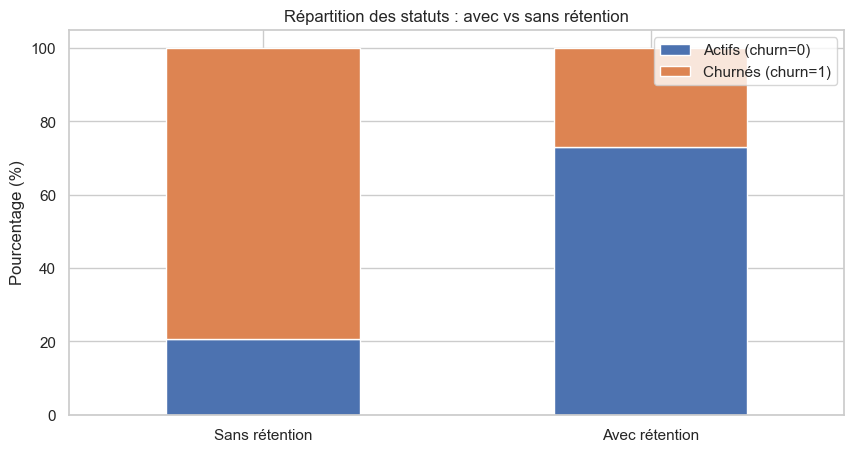

In [43]:
df_q2 = (
    df.groupby("has_retention")["churn"]
      .agg(churn_rate="mean", n="count")
      .reset_index()
)
df_q2["churn_rate_pct"] = 100 * df_q2["churn_rate"]
df_q2["has_retention"] = df_q2["has_retention"].map({False: "Sans rétention", True: "Avec rétention"})
print(df_q2)

ax = sns.barplot(data=df_q2, x="has_retention", y="churn_rate_pct")
ax.set_title("Taux de churn observé : avec vs sans rétention")
ax.set_xlabel("")
ax.set_ylabel("Churn rate (%)")
for i, row in df_q2.iterrows():
    ax.text(i, row["churn_rate_pct"] + 1, f'{row["churn_rate_pct"]:.1f}%', ha="center")
plt.show()

tab = pd.crosstab(df["has_retention"], df["churn"], normalize="index") * 100
tab.index = tab.index.map({False: "Sans rétention", True: "Avec rétention"})
tab.columns = ["Actifs (churn=0)", "Churnés (churn=1)"]
print(tab)

ax = tab.plot(kind="bar", stacked=True)
ax.set_title("Répartition des statuts : avec vs sans rétention")
ax.set_xlabel("")
ax.set_ylabel("Pourcentage (%)")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()


In [113]:
churn_by_ret = (
    df.groupby("has_retention")["churn"]
      .mean()
      .reset_index()
)

print(churn_by_ret)

   has_retention     churn
0          False  0.794501
1           True  0.268595


# Couche de décision de rétention orientée métier

  risk_segment  n_users  churn_rate  churn_rate_pct
0     Low risk     2855    0.023117        2.311734
1  Medium risk      352    0.974432       97.443182
2    High risk     9170    1.000000      100.000000


C:\Users\setup game\AppData\Local\Temp\ipykernel_26544\427773419.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("risk_segment")


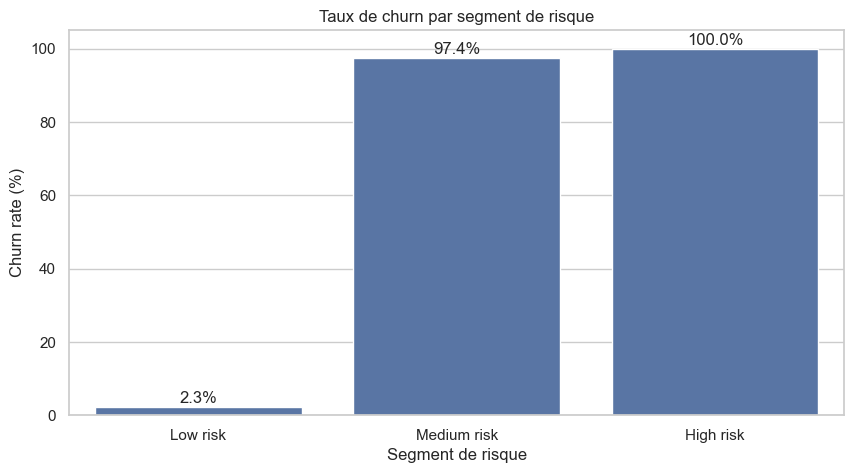

In [44]:
df["risk_segment"] = pd.cut(
    df["p_churn"],
    bins=[0, 0.3, 0.7, 1.0],
    labels=["Low risk", "Medium risk", "High risk"]
)

segment_summary = (
    df.groupby("risk_segment")
      .agg(
          n_users=("churn", "count"),
          churn_rate=("churn", "mean")
      )
      .reset_index()
)

segment_summary["churn_rate_pct"] = 100 * segment_summary["churn_rate"]
print(segment_summary)

ax = sns.barplot(
    data=segment_summary,
    x="risk_segment",
    y="churn_rate_pct"
)
ax.set_title("Taux de churn par segment de risque")
ax.set_xlabel("Segment de risque")
ax.set_ylabel("Churn rate (%)")

for i, row in segment_summary.iterrows():
    ax.text(i, row["churn_rate_pct"] + 1, f"{row['churn_rate_pct']:.1f}%", ha="center")

plt.show()